In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import Sequential
from keras.activations import relu, softmax
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import ParameterGrid

2023-07-14 13:20:48.316909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Übungsblatt 4 (komische Zählung)

## Aufgabe 1: CNN beim MNIST Datensatz

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
param_grid = ParameterGrid({
    'kernel_size': [(3, 3), (4, 4), (5, 5)],
    'pool_size': [(3, 3), (4, 4), (5, 5)],
})

In [4]:
def score(kernel_size, pool_size):
    model = Sequential()
    model.add(Conv2D(28, kernel_size=kernel_size, input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(128, activation=relu))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation=softmax))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x=x_train[:5000], y=y_train[:5000], epochs=3)

    (loss, accuracy) = model.evaluate(x_test, y_test)

    predictions = model.predict(x_test)
    y_predicted = predictions.argmax(axis=-1)
    return {
        'loss': loss,
        'accuracy': accuracy,
        'f1': f1_score(y_test, y_predicted, average='micro'),
        'recall': recall_score(y_test, y_predicted, average='micro'),
        'precision': precision_score(y_test, y_predicted, average='micro')
    }


scores = pd.DataFrame({tuple(params.values()): score( **params) for params in param_grid}).T

Epoch 1/3


2023-07-14 13:20:50.504210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 13:20:50.505446: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


157/157 [==============================] - 11s 66ms/step - loss: 4.0262 - accuracy: 0.6828
Epoch 2/3
157/157 [==============================] - 12s 79ms/step - loss: 0.6111 - accuracy: 0.8304
Epoch 3/3
313/313 [==============================] - 6s 19ms/step
Epoch 1/3
157/157 [==============================] - 9s 54ms/step - loss: 5.5865 - accuracy: 0.6332
Epoch 2/3
157/157 [==============================] - 6s 39ms/step - loss: 0.7343 - accuracy: 0.7976
Epoch 3/3
313/313 [==============================] - 2s 5ms/step
Epoch 1/3
157/157 [==============================] - 4s 24ms/step - loss: 4.6178 - accuracy: 0.6364
Epoch 2/3
157/157 [==============================] - 3s 21ms/step - loss: 0.7033 - accuracy: 0.7984
Epoch 3/3
313/313 [==============================] - 1s 2ms/step
Epoch 1/3
157/157 [==============================] - 10s 59ms/step - loss: 3.9598 - accuracy: 0.7316
Epoch 2/3
157/157 [==============================] - 8s 50ms/step - loss: 0.4718 - accuracy: 0.8706
Epoch 3/3
3

In [5]:
scores

loss  accuracy      f1  recall  precision
(3, 3) (3, 3)  0.407607    0.8985  0.8985  0.8985     0.8985
       (4, 4)  0.468202    0.8792  0.8792  0.8792     0.8792
       (5, 5)  0.360663    0.8997  0.8997  0.8997     0.8997
(4, 4) (3, 3)  0.335703    0.9156  0.9156  0.9156     0.9156
       (4, 4)  0.310890    0.9140  0.9140  0.9140     0.9140
       (5, 5)  0.305475    0.9217  0.9217  0.9217     0.9217
(5, 5) (3, 3)  0.411587    0.8940  0.8940  0.8940     0.8940
       (4, 4)  0.391525    0.9077  0.9077  0.9077     0.9077
       (5, 5)  0.353627    0.9030  0.9030  0.9030     0.9030

In [6]:
# Kernel
scores.groupby(level=[0]).mean()

,loss,accuracy,f1,recall,precision
"(3, 3)",0.412157,0.892467,0.892467,0.892467,0.892467
"(4, 4)",0.317356,0.917100,0.917100,0.917100,0.917100
"(5, 5)",0.385579,0.901567,0.901567,0.901567,0.901567


In [7]:
# Pooling
scores.groupby(level=[1]).mean()

,loss,accuracy,f1,recall,precision
"(3, 3)",0.384966,0.902700,0.902700,0.902700,0.902700
"(4, 4)",0.390206,0.900300,0.900300,0.900300,0.900300
"(5, 5)",0.339921,0.908133,0.908133,0.908133,0.908133


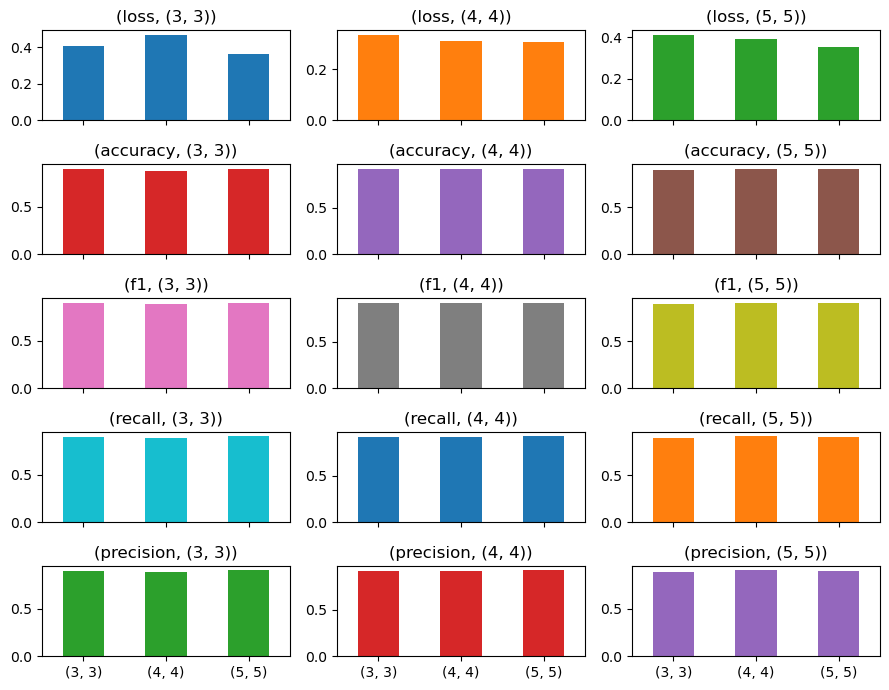

In [8]:
# Kernel
scores.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(5, 3), legend=False)
plt.tight_layout()

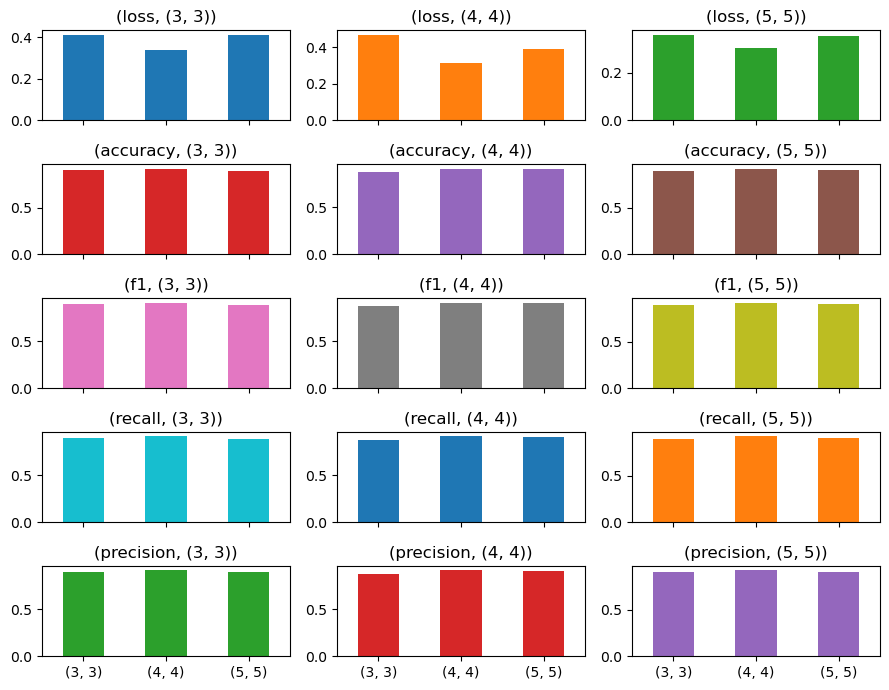

In [9]:
# Pooling
scores.unstack(level=1).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(5, 3), legend=False)
plt.tight_layout()

## Aufgabe 2: Implementieren der Principal Component Analysis
https://wendynavarrete.com/principal-component-analysis-with-numpy/

In [10]:
# get some data
iris = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", names=["sepal_length","sepal_width",'petal_length','petal_width','species'])
iris = iris.drop(columns=["species"])
iris

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [11]:
# normalize it
normalized_iris=(iris-iris.mean())/iris.std()
normalized_iris

,sepal_length,sepal_width,petal_length,petal_width
0,-0.897674,1.028611,-1.336794,-1.308593
1,-1.139200,-0.124540,-1.336794,-1.308593
2,-1.380727,0.336720,-1.393470,-1.308593
3,-1.501490,0.106090,-1.280118,-1.308593
4,-1.018437,1.259242,-1.336794,-1.308593
...,...,...,...,...
145,1.034539,-0.124540,0.816888,1.443121
146,0.551486,-1.277692,0.703536,0.918985
147,0.793012,-0.124540,0.816888,1.050019
148,0.430722,0.797981,0.930239,1.443121


In [12]:
# calculate covariance matrix
covariance_matrix = np.cov(normalized_iris.T)
covariance_matrix

array([[ 1.        , -0.10936925,  0.87175416,  0.81795363],
       [-0.10936925,  1.        , -0.4205161 , -0.35654409],
       [ 0.87175416, -0.4205161 ,  1.        ,  0.9627571 ],
       [ 0.81795363, -0.35654409,  0.9627571 ,  1.        ]])

In [13]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

In [14]:
eigenvalues

array([2.91081808, 0.92122093, 0.14735328, 0.02060771])

In [15]:
eigenvectors

array([[ 0.52237162, -0.37231836, -0.72101681,  0.26199559],
       [-0.26335492, -0.92555649,  0.24203288, -0.12413481],
       [ 0.58125401, -0.02109478,  0.14089226, -0.80115427],
       [ 0.56561105, -0.06541577,  0.6338014 ,  0.52354627]])

In [16]:
# calculate explained variance to decide how many dimensions to keep
variance_explained = eigenvalues/eigenvalues.sum()
variance_explained

array([0.72770452, 0.23030523, 0.03683832, 0.00515193])

In [17]:
projected = normalized_iris.dot(eigenvectors[:,:2])
projected

,0,1
0,-2.256981,-0.504015
1,-2.079459,0.653216
2,-2.360044,0.317414
3,-2.296504,0.573447
4,-2.380802,-0.672514
...,...,...
145,1.864277,-0.381544
146,1.553288,0.902291
147,1.515767,-0.265904
148,1.371796,-1.012968
